<a href="https://colab.research.google.com/github/peremartra/Rearchitecting-LLMs/blob/main/CH06/CH06_NB02_Width_Pruned_Model_Recovery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table style="width:100%; border:none; background:none;">
  <tr style="border:none;">
    <td style="border:none; vertical-align:middle; text-align:left; width: 120px;">
      <a href="https://hubs.la/Q040tvsK0"><img src="https://raw.githubusercontent.com/peremartra/Rearchitecting-LLMs/main/Images/cover.png" width="100px" style="border-radius: 4px;"></a>
    </td>
    <td style="border:none; vertical-align:middle; text-align:left;">
      <p style="margin: 0; font-size: 14px;">
        Supplementary code for the <a href="https://hubs.la/Q040tvsK0">Rearchitecting LLMs</a> book by <a href="https://github.com/peremartra">Pere Martra</a>.<br>
        <br>
        <strong>MEAP Special:</strong> Get it at 50% off with code <strong>MLMartra</strong> (valid until Feb 26th).<br>
        <br>
        Code repository: <a href="https://github.com/peremartra/Rearchitecting-LLMs">https://github.com/peremartra/Rearchitecting-LLMs</a>
      </p>
    </td>
  </tr>
</table>

# **Rearchitecting LLMs**
## **Chapter 6: Knowledge Recovery**
### Recovering from width pruning.

[![LinkedIn](https://img.shields.io/badge/LinkedIn-0077B5?style=flat&logo=linkedin&logoColor=white)](https://www.linkedin.com/in/pere-martra/) [![GitHub](https://img.shields.io/badge/GitHub-100000?style=flat&logo=github&logoColor=white)](https://github.com/peremartra) [![X](https://img.shields.io/badge/X-000000?style=flat&logo=x&logoColor=white)](https://x.com/PereMartra) [![Hugging Face](https://img.shields.io/badge/🤗%20Hugging%20Face-blue)](https://huggingface.co/oopere)

---

**Hardware Environment:** NVIDIA T4 GPU
- **Model:** Qwen/Qwen3-0.6B
- **Dataset:** Cosmopedia (200 samples, 5 epochs)

---

## Overview

This notebook demonstrates **Knowledge Distillation** for recovering performance in a width-pruned model.

### Training Configuration
- **Dataset**: Cosmopedia (200 samples from 4 subsets: stories, wikihow, openstax, web_samples_v1)
- **Training**: 5 epochs, learning rate 2e-5, batch size 2
- **Hardware**: NVIDIA T4 GPU
- **Distillation Method**: Advanced KD with Skew KLD + Feature Dynamics Distillation (FDD)
- **Layer Mapping**: Selected-Layer strategy (maintains original indices)
- **Training Time**: 8.9 minutes

## Setting up notebook

In [ ]:
#Samples in the training dataset.
RECOVERY_SAMPLES = 200

EPOCHS=5
LEARNING_RATE=2e-5  #1e-5
BATCH_SIZE = 1

# Flag to skip benchmarks during development (set to True for final run)
RUN_FULL_BENCHMARKS = True
BENCHMARK_LIMIT = 100  #From 100 for quick testing to None for full evaluation
BENCHMARK_TASKS = [
      "arc_easy",
      "winogrande",
      "hellaswag",
      "lambada_openai",
      "piqa"
] # Define benchmark tasks


In [ ]:
# Install required packages
!pip install -q transformers accelerate datasets
!pip install -q optipfair  # For creating pruned model on-the-fly
!pip install -q matplotlib seaborn tqdm
!pip install -q lm_eval
!pip install -q langdetect
!pip install -q codecarbon

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 111.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.8/100.8 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.1/91.1 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 22.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 359.6/359.6 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.6/155.6 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 90.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch, gc
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    TrainingArguments,
    Trainer
)
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm.auto import tqdm
from copy import deepcopy
import warnings

warnings.filterwarnings('ignore')

# Check PyTorch version and device
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

PyTorch version: 2.9.0+cu126
CUDA available: True
Using device: cuda


In [ ]:
def set_seed(seed=42):
    """Set random seed for reproducibility"""
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

set_seed(42)
print("✓ Random seed set to 42")

✓ Random seed set to 42


In [ ]:
# Download utils.py from GitHub repository
!wget -q https://raw.githubusercontent.com/peremartra/Rearchitecting-LLMs/main/utils.py

# Verify download
import os
if os.path.exists('utils.py'):
    print("✅ utils.py downloaded successfully")
else:
    print("❌ Failed to download utils.py")

from utils import (
    evaluate_metrics,  # Loss & Perplexity
    clear_gpu_cache
)

## Load Models and Create Pruned Student

In [ ]:
MODEL_NAME = "Qwen/Qwen3-0.6B"

print(f"Loading Teacher model: {MODEL_NAME}")
teacher_model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float32,
    device_map="auto" if torch.cuda.is_available() else None
)

# Freeze teacher (we never update it)
teacher_model.eval()
for param in teacher_model.parameters():
    param.requires_grad = False

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Print architecture info
n_teacher_layers = len(teacher_model.model.layers)
hidden_dim = teacher_model.config.hidden_size

print(f"\n{'='*60}")
print(f"Teacher Model: {MODEL_NAME}")
print(f"{'='*60}")
print(f"Total layers: {n_teacher_layers}")
print(f"Hidden dimension: {hidden_dim}")
print(f"Total parameters: {teacher_model.num_parameters():,}")
print(f"Memory footprint: {teacher_model.get_memory_footprint() / 1e9:.2f} GB")
print(f"{'='*60}\n")

## 6.1.2 Prepare Training Dataset

In [ ]:
from datasets import load_dataset, Dataset
from tqdm.auto import tqdm
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split

# Define tokenization parameters
MAX_LENGTH = 512

def tokenize_function(examples):
    """Tokenize text samples for training"""
    texts = examples['text'] if isinstance(examples, dict) else examples
    return tokenizer(
        texts,
        truncation=True,
        padding="max_length",
        max_length=MAX_LENGTH,
        return_tensors="pt"
    )

print(f"✓ Tokenization function ready (max_length={MAX_LENGTH})")

# Load Cosmopedia dataset
print("\nLoading Cosmopedia dataset...")
dataset_name = "HuggingFaceTB/cosmopedia"
subsets = ["stories", "wikihow", "openstax", "web_samples_v1"]
samples_per_subset = int(RECOVERY_SAMPLES / 4)
num_samples = samples_per_subset * len(subsets)

print(f"Loading {len(subsets)} subsets with {samples_per_subset:,} samples each...")

all_samples = []
for subset in subsets:
    print(f"  Loading {subset}...")
    subset_data = load_dataset(dataset_name, subset, split="train", streaming=True)
    subset_samples = list(subset_data.take(samples_per_subset))
    all_samples.extend(subset_samples)
    print(f"    ✓ {len(subset_samples):,} samples from {subset}")

print(f"✓ Total samples loaded: {len(all_samples):,}")

# Convert to HuggingFace Dataset
distillation_dataset = Dataset.from_dict({'text': [s['text'] for s in all_samples]})
print(f"✓ Cosmopedia dataset ready: {len(distillation_dataset):,} samples")

# ==============================================================================
# Tokenization and Train/Val Split
# ==============================================================================

print("\nPreparing DataLoader with Train/Val split...")

# 1. Tokenize all samples
print("  Converting dataset to list...")
dataset_list = list(distillation_dataset)
texts = [item['text'] for item in dataset_list]

print(f"  Tokenizing {len(texts):,} samples...")
tokenized_data = []
batch_size = 1000
for i in tqdm(range(0, len(texts), batch_size), desc="Tokenizing"):
    batch_texts = texts[i:i+batch_size]
    batch_tokens = tokenizer(
        batch_texts,
        truncation=True,
        padding="max_length",
        max_length=MAX_LENGTH,
        return_tensors="pt"
    )
    tokenized_data.append(batch_tokens)

# Combine all batches
input_ids = torch.cat([batch['input_ids'] for batch in tokenized_data], dim=0)
attention_mask = torch.cat([batch['attention_mask'] for batch in tokenized_data], dim=0)

# 2. Create full dataset
full_dataset = TensorDataset(input_ids, attention_mask)

# 3. Split into Train (90%) and Validation (10%)
# This prevents overfitting metrics - we now evaluate on UNSEEN data
# Using fixed seed for reproducibility across runs
generator = torch.Generator().manual_seed(42)
train_size = int(0.9 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(
    full_dataset,
    [train_size, val_size],
    generator=generator
)

# 4. Create TWO independent DataLoaders
# Train DataLoader: shuffle=True for better learning
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

# Validation DataLoader: shuffle=False (not needed for evaluation)
# This is used for computing unbiased PPL metrics
eval_dataloader_raw = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print(f"\n✓ DataLoaders ready:")
print(f"  Total samples: {len(full_dataset):,}")
print(f"  - Training samples: {len(train_dataset):,} ({len(train_dataloader):,} batches)")
print(f"  - Validation samples: {len(val_dataset):,} ({len(eval_dataloader_raw):,} batches)")
print(f"  Batch size: {BATCH_SIZE}")
print(f"\n⚠️  IMPORTANT: PPL is now computed on validation set (not training data)")
print(f"  This provides honest generalization metrics")

# ==============================================================================
# Code for Evaluations (wrapper class)
# ==============================================================================

class DictDataLoader:
    """Wrapper to convert TensorDataset tuples to dictionaries"""
    def __init__(self, dataloader):
        self.dataloader = dataloader

    def __iter__(self):
        for input_ids, attention_mask in self.dataloader:
            yield {
                'input_ids': input_ids,
                'attention_mask': attention_mask
            }

    def __len__(self):
        return len(self.dataloader)

eval_dataloader = DictDataLoader(eval_dataloader_raw)


### Pruned model

In [ ]:
import optipfair as opf
student_model = deepcopy(teacher_model)

student_model = opf.prune_model(
    model=student_model,
    pruning_type="MLP_GLU",          # Specify width pruning on MLP
    neuron_selection_method="PPM",   # Peak-to-Peak Magnitude (PPM) Method
    pruning_percentage=10,           # Percentatge to remove (10%)
    show_progress=True,              # Progress bar
)

# IMPORTANT: Unfreeze student parameters!
# The deepcopy inherited requires_grad=False from the frozen teacher
for param in student_model.parameters():
    param.requires_grad = True

# Get student info
n_student_layers = len(student_model.model.layers)


In [ ]:
# Evaluate Teacher (baseline)
print("Evaluating Teacher...")
teacher_metrics = evaluate_metrics(teacher_model, eval_dataloader, device=device)
teacher_loss = teacher_metrics['loss']
teacher_ppl = teacher_metrics['perplexity']

if RUN_FULL_BENCHMARKS:
  from utils import model_evaluation
  benchmark_results = {}
  results = model_evaluation(
      model_obj=teacher_model,
      tokenizer=tokenizer,
      tasks=BENCHMARK_TASKS,
      device=device,
      limit=BENCHMARK_LIMIT,
      batch_size="auto" #4
      )
  benchmark_results['teacher'] = results

In [ ]:
#del teacher_model
#clear_gpu_cache()

In [ ]:
# Evaluate Student (baseline)
print("Evaluating Pruned Student (no training)...")
student_pruned = deepcopy(student_model)
student_metrics = evaluate_metrics(student_pruned, eval_dataloader, device=device)
student_loss = student_metrics['loss']
student_ppl = student_metrics['perplexity']

if RUN_FULL_BENCHMARKS:
    results = model_evaluation(
    model_obj=student_pruned,
    tokenizer=tokenizer,
    tasks=BENCHMARK_TASKS,
    device=device,
    limit=BENCHMARK_LIMIT,
    batch_size="auto" #4
    )

    benchmark_results['student_pruned'] = results

## 6.2 Implement Layer Mapping Strategies

## 6.3.1 Implement Compound Loss + 6.4

This function is created with the code from Listing 6.6 section 6.3.1 in the book plus the additions from section 6.4 Advanced Recovery (Skew KLD / Feature Dynamics Distillation).

In [ ]:
def compute_compound_loss_advanced(
    student_logits,      # [batch, seq_len, vocab_size]
    teacher_logits,      # [batch, seq_len, vocab_size]
    student_hiddens,     # List of [batch, seq_len, hidden_dim] or None
    teacher_hiddens,     # List of [batch, seq_len, hidden_dim] or None
    labels,              # [batch, seq_len]
    layer_map=None,      # List of teacher indices for each student layer
    alpha=0.1,           # weight for task loss
    beta=0.8,            # weight for logits loss (Skew KLD)
    gamma=0.1,           # weight for hidden trajectory loss
    delta=0.1,           # weight for FDD derivative loss
    temperature=2.0,     # temperature for soft labels
    skew_alpha=0.1       # interpolation factor for Skew KLD (0=Forward, 1=Reverse)
):
    """
    Advanced compound loss combining state-of-the-art techniques:

    1. Task Loss: Standard cross-entropy with hard labels
    2. Skew KLD: Interpolates between Forward and Reverse KLD (DistiLLM-2)
       - Forward KLD (α=0): Student covers all teacher modes (mean-seeking)
       - Reverse KLD (α=1): Student focuses on high-confidence modes (mode-seeking)
       - Skew (α=0.1): Best of both worlds, numerically stable
    3. Trajectory Loss: Cosine similarity between hidden states (standard feature KD)
    4. FDD Derivative Loss: Aligns the "rate of change" between consecutive layers
       - Forces student to learn HOW to transform representations, not just WHAT to produce
       - Critical for depth-pruned models that must take "bigger steps" with fewer layers

    Reference:
    - Skew KLD: DistiLLM-2 (2024)
    - FDD: Feature Dynamics Distillation, ACL 2025
    """
    device = student_logits.device

    # =========================================================================
    # 1. TASK LOSS (Cross-Entropy with hard labels)
    # =========================================================================
    shift_logits = student_logits[..., :-1, :].contiguous()
    shift_labels = labels[..., 1:].contiguous()

    loss_task = F.cross_entropy(
        shift_logits.view(-1, shift_logits.size(-1)),
        shift_labels.view(-1),
        ignore_index=-100
    )

    # =========================================================================
    # 2. SKEW KLD (Interpolated Divergence for Logits)
    # =========================================================================
    # Standard softmax with temperature
    with torch.no_grad():
        student_probs = F.softmax(student_logits[..., :-1, :] / temperature, dim=-1)
        teacher_probs = F.softmax(teacher_logits[..., :-1, :] / temperature, dim=-1)

        # Skew: interpolate between teacher and student distributions
        # When skew_alpha=0.1: 90% teacher + 10% student (slight mode-seeking bias)
        mixed_probs = skew_alpha * student_probs + (1 - skew_alpha) * teacher_probs

    # KL divergence against the mixed target
    student_log_probs = F.log_softmax(student_logits[..., :-1, :] / temperature, dim=-1)
    kl_elementwise = student_probs * (student_log_probs - torch.log(mixed_probs + 1e-9))
    loss_logits = kl_elementwise.sum(dim=-1).mean() * (temperature ** 2)

    # =========================================================================
    # 3. TRAJECTORY LOSS (Cosine Similarity of Hidden States)
    # =========================================================================
    # Standard feature alignment - matches "where" the student is in representation space
    # Only compute if gamma > 0 and we have hidden states
    if gamma > 0 and student_hiddens is not None and teacher_hiddens is not None:
        loss_trajectory = 0.0
        for student_idx, teacher_idx in enumerate(layer_map):
            student_h = student_hiddens[student_idx]
            teacher_h = teacher_hiddens[teacher_idx]

            # Flatten and normalize
            student_flat = student_h.reshape(-1, student_h.size(-1))
            teacher_flat = teacher_h.reshape(-1, teacher_h.size(-1))
            student_norm = F.normalize(student_flat, p=2, dim=1)
            teacher_norm = F.normalize(teacher_flat, p=2, dim=1)

            # Cosine similarity loss: 1 - cos_sim (0 = perfect alignment)
            cos_sim = (student_norm * teacher_norm).sum(dim=1).mean()
            loss_trajectory += (1 - cos_sim)

        loss_trajectory = loss_trajectory / len(layer_map)
    else:
        loss_trajectory = torch.tensor(0.0, device=device)

    # =========================================================================
    # 4. FDD DERIVATIVE LOSS (Feature Dynamics Distillation)
    # =========================================================================
    # Matches the "velocity" of representation change between consecutive layers
    # Key insight: In residual networks, x_{l+1} = x_l + F(x_l)
    # The delta F(x_l) represents how much the layer transforms the representation
    # A depth-pruned student must learn to make larger, more efficient transformations
    # Only compute if delta > 0 and we have hidden states
    loss_derivative = torch.tensor(0.0, device=device)

    if delta > 0 and student_hiddens is not None and teacher_hiddens is not None:
        num_derivatives = 0

        for student_idx in range(len(layer_map) - 1):
            teacher_idx = layer_map[student_idx]
            teacher_idx_next = layer_map[student_idx + 1]

            # Student delta: change between consecutive student layers
            student_delta = student_hiddens[student_idx + 1] - student_hiddens[student_idx]

            # Teacher delta: change between corresponding teacher layers
            teacher_delta = teacher_hiddens[teacher_idx_next] - teacher_hiddens[teacher_idx]

            # Flatten and normalize the deltas
            student_delta_flat = student_delta.reshape(-1, student_delta.size(-1))
            teacher_delta_flat = teacher_delta.reshape(-1, teacher_delta.size(-1))

            student_delta_norm = F.normalize(student_delta_flat, p=2, dim=1)
            teacher_delta_norm = F.normalize(teacher_delta_flat, p=2, dim=1)

            # Cosine similarity of derivatives
            cos_sim_deriv = (student_delta_norm * teacher_delta_norm).sum(dim=1).mean()
            loss_derivative += (1 - cos_sim_deriv)
            num_derivatives += 1

        if num_derivatives > 0:
            loss_derivative = loss_derivative / num_derivatives

    # =========================================================================
    # COMBINE ALL LOSSES
    # =========================================================================
    total_loss = (
        alpha * loss_task +
        beta * loss_logits +
        gamma * loss_trajectory +
        delta * loss_derivative
    )

    loss_dict = {
        'total': total_loss.item(),
        'task': loss_task.item(),
        'logits': loss_logits.item(),
        'trajectory': loss_trajectory.item(),
        'derivative': loss_derivative.item()
    }

    return total_loss, loss_dict

## 6.3.2 Training Loop Implementation
The code for the train_student_advanced function is the same as the one that can be found in listing 6.7 of the book, with the necessary modifications to call the compute_compound_loss_advanced function.

In [ ]:
def train_student_advanced(
    student_model,
    teacher_model,
    dataloader,
    layer_map,
    # Loss weights
    alpha=0.1,           # Task loss
    beta=0.8,            # Skew KLD (logits)
    gamma=0.05,          # Trajectory loss (hidden states)
    delta=0.05,          # FDD derivative loss
    temperature=2.0,
    skew_alpha=0.5,      # Skew interpolation factor
    # Training params
    epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    experiment_name="experiment",
    accumulation_steps=4
):
    """
    Train student model with Advanced Compound Loss (Skew KLD + FDD).
    """
    optimizer = torch.optim.AdamW(student_model.parameters(), lr=learning_rate)

    student_model.train()
    teacher_model.eval()
    if layer_map is None:
        num_layers = student_model.config.num_hidden_layers
        layer_map = list(range(num_layers))
        print(f"Auto-configured layer_map 1:1 for {num_layers} layers.")

    # Decide if we need hidden states (required if using trajectory OR derivative loss)
    request_hidden_states = (gamma > 0 or delta > 0)

    loss_history = {
        'total': [], 'task': [], 'logits': [],
        'trajectory': [], 'derivative': []
    }
    epoch_times = []

    print(f"\n{'='*60}")
    print(f"Starting Training: {experiment_name}")
    print(f"{'='*60}")
    print(f"Epochs: {epochs}")
    print(f"Learning rate: {learning_rate}")
    print(f"Loss weights: α={alpha}, β={beta}, γ={gamma}, δ={delta}")
    print(f"Temperature: {temperature}, Skew α: {skew_alpha}")
    print(f"Hidden states computation: {'ENABLED' if request_hidden_states else 'DISABLED'}")
    print(f"Gradient Accumulation Steps: {accumulation_steps}")
    print(f"Effective Batch Size: {dataloader.batch_size * accumulation_steps}")
    print(f"{'='*60}\n")

    total_start_time = time.time()

    for epoch in range(epochs):
        epoch_start_time = time.time()

        epoch_losses = {k: [] for k in loss_history.keys()}
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")

        accumulated_losses = {k: 0.0 for k in loss_history.keys()}
        accumulation_counter = 0

        for batch_idx, (input_ids, attention_mask) in enumerate(progress_bar):
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = input_ids.clone()

            # Student forward pass
            student_outputs = student_model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                output_hidden_states=request_hidden_states
            )

            # Teacher forward pass (no gradients)
            with torch.no_grad():
                teacher_outputs = teacher_model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    output_hidden_states=request_hidden_states
                )

            # Prepare hidden states (None if not needed)
            student_hiddens = (student_outputs.hidden_states[1:]
                             if request_hidden_states else None)
            teacher_hiddens = (teacher_outputs.hidden_states[1:]
                             if request_hidden_states else None)

            # Compute advanced compound loss
            loss, loss_dict = compute_compound_loss_advanced(
                student_logits=student_outputs.logits,
                teacher_logits=teacher_outputs.logits,
                student_hiddens=student_hiddens,
                teacher_hiddens=teacher_hiddens,
                labels=labels,
                layer_map=layer_map,
                alpha=alpha,
                beta=beta,
                gamma=gamma,
                delta=delta,
                temperature=temperature,
                skew_alpha=skew_alpha
            )

            # Gradient accumulation
            scaled_loss = loss / accumulation_steps
            scaled_loss.backward()

            for key in accumulated_losses:
                accumulated_losses[key] += loss_dict[key]
            accumulation_counter += 1

            # Optimizer step
            if (batch_idx + 1) % accumulation_steps == 0:
                torch.nn.utils.clip_grad_norm_(student_model.parameters(), max_norm=1.0)
                optimizer.step()
                optimizer.zero_grad()

                avg_losses = {k: v / accumulation_counter for k, v in accumulated_losses.items()}
                for key in avg_losses:
                    epoch_losses[key].append(avg_losses[key])

                progress_bar.set_postfix({
                    'loss': f"{avg_losses['total']:.4f}",
                    'task': f"{avg_losses['task']:.4f}",
                    'logits': f"{avg_losses['logits']:.4f}",
                    'traj': f"{avg_losses['trajectory']:.4f}",
                    'deriv': f"{avg_losses['derivative']:.4f}"
                })

                accumulated_losses = {k: 0.0 for k in loss_history.keys()}
                accumulation_counter = 0

        # Handle remaining batches
        if accumulation_counter > 0:
            torch.nn.utils.clip_grad_norm_(student_model.parameters(), max_norm=1.0)
            optimizer.step()
            optimizer.zero_grad()

            avg_losses = {k: v / accumulation_counter for k, v in accumulated_losses.items()}
            for key in avg_losses:
                epoch_losses[key].append(avg_losses[key])

        # Record epoch averages
        for key in epoch_losses:
            if epoch_losses[key]:
                loss_history[key].append(np.mean(epoch_losses[key]))

        epoch_time = time.time() - epoch_start_time
        epoch_times.append(epoch_time)

        print(f"Epoch {epoch+1} avg losses - "
              f"Total: {loss_history['total'][-1]:.4f}, "
              f"Task: {loss_history['task'][-1]:.4f}, "
              f"Logits: {loss_history['logits'][-1]:.4f}, "
              f"Traj: {loss_history['trajectory'][-1]:.4f}, "
              f"Deriv: {loss_history['derivative'][-1]:.4f} "
              f"[{epoch_time:.1f}s]")

    total_time = time.time() - total_start_time
    loss_history['epoch_times_seconds'] = epoch_times
    loss_history['total_time_seconds'] = total_time

    print(f"\n✓ Training completed: {experiment_name}")
    print(f"  Total time: {total_time:.1f}s ({total_time/60:.1f} min)")
    print(f"  Avg time per epoch: {np.mean(epoch_times):.1f}s")

    return student_model, loss_history



Advanced KD (Skew KLD + FDD)


In [ ]:
# Train with Advanced KD
import time

student_sel_advanced_trained, history_sel_advanced = train_student_advanced(
    student_model=student_model,
    teacher_model=teacher_model,
    dataloader=train_dataloader,
    layer_map=None,
    alpha=0.2,           # Task loss weight
    beta=0.5,            # Skew KLD weight
    gamma=0.1,           # Trajectory (hidden) weight
    delta=0.2,           # FDD derivative weight
    temperature=2.0,
    skew_alpha=0.5,      # Slight mode-seeking bias
    epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    experiment_name="Selected Layers Advanced KD (Skew KLD + FDD)"
)

In [ ]:
# Evaluate Advanced KD
print("Evaluating Advanced KD (Skew KLD + FDD)...")
advanced_sel_metrics = evaluate_metrics(student_sel_advanced_trained, eval_dataloader, device=device)
advanced_sel_loss = advanced_sel_metrics['loss']
advanced_sel_ppl = advanced_sel_metrics['perplexity']

if RUN_FULL_BENCHMARKS:
  results = model_evaluation(
      model_obj=student_sel_advanced_trained,
      tokenizer=tokenizer,
      tasks=BENCHMARK_TASKS,
      device=device,
      limit=BENCHMARK_LIMIT,
      batch_size=16 #4
  )

  benchmark_results['selected_advanced_kd'] = results

Evaluating Advanced KD (Skew KLD + FDD)...


Evaluating: 100%|██████████| 20/20 [00:05<00:00,  3.43it/s]


Starting lm-eval on model 'Qwen/Qwen3-0.6B' for tasks: ['arc_easy', 'winogrande', 'hellaswag', 'lambada_openai', 'piqa']

Tasks grouped by few-shot: {0: ['arc_easy', 'winogrande', 'hellaswag', 'lambada_openai', 'piqa']} (limit=100)
Task-level few-shot config: {'arc_easy': 0, 'winogrande': 0, 'hellaswag': 0, 'lambada_openai': 0, 'piqa': 0}

Evaluating 5 task(s) with 0-shot learning...


Running loglikelihood requests: 100%|██████████| 1299/1299 [01:16<00:00, 16.94it/s]


bootstrapping for stddev: perplexity


100%|██████████| 100/100 [00:00<00:00, 404.30it/s]


In [ ]:
del student_sel_advanced_trained
clear_gpu_cache()

## Evaluation and Comparison
The data in this notebook isn't reliable since it's been obtained using very few sample records, both for perplexity and for capabilities. To analyze the data it's better to go to the notebooks of the chapter experiments.

In [ ]:
# Calculate recovery rates
def recovery_rate(teacher_ppl, pruned_ppl, recovered_ppl):
    """Calculate recovery rate as percentage"""
    degradation = pruned_ppl - teacher_ppl
    recovery = pruned_ppl - recovered_ppl
    return (recovery / degradation) * 100 if degradation > 0 else 0


In [ ]:

advanced_sel_recovery = recovery_rate(teacher_ppl, student_ppl, advanced_sel_ppl)


# Print results table
print("\n" + "="*80)
print("EVALUATION RESULTS")
print("="*80)
print(f"{'Model':<40} {'Loss':>10} {'Perplexity':>12} {'Recovery':>12}")
print("-"*80)
print(f"{'Teacher (Original)':<40} {teacher_loss:>10.4f} {teacher_ppl:>12.2f} {'100.0%':>12}")
print(f"{'Student (Pruned, no training)':<40} {student_loss:>10.4f} {student_ppl:>12.2f} {'0.0%':>12}")
print("-"*80)
print(f"{'Selected  (Skew KLD + FDD)':<40} {advanced_sel_loss:>10.4f} {advanced_sel_ppl:>12.2f} {f'{advanced_sel_recovery:.1f}%':>12}")
print("="*80)


EVALUATION RESULTS
Model                                          Loss   Perplexity     Recovery
--------------------------------------------------------------------------------
Teacher (Original)                           2.4272        11.33       100.0%
Student (Pruned, no training)                3.4547        31.65         0.0%
--------------------------------------------------------------------------------
Selected  (Skew KLD + FDD)                   2.6498        14.15        86.1%


In [ ]:
# Benchmark Evaluation
if RUN_FULL_BENCHMARKS:

    # Display comparison table
    print("\n" + "="*90)
    print("BENCHMARK COMPARISON TABLE")
    print("="*90)

    # Header
    header = f"{'Model':<25}"
    for task in BENCHMARK_TASKS:
        header += f"{task:<14}"

    print(header)
    print("-"*90)

    # Rows
    for model_name, results in benchmark_results.items():
        row = f"{model_name:<25}"
        for task in BENCHMARK_TASKS:
            if task in results and "error" not in results:
                # Get accuracy or acc_norm depending on task
                metrics = results[task]
                if "acc_norm" in metrics:
                    val = float(metrics["acc_norm"])
                elif "accuracy" in metrics:
                    val = float(metrics["accuracy"])
                else:
                    val = 0.0
                row += f"{val:.4f}        "
            else:
                row += f"{'N/A':<14}"
        print(row)

    print("="*90)

else:
    print("⚠️ Benchmark evaluation skipped (RUN_FULL_BENCHMARKS = False)")
    benchmark_results = {}


BENCHMARK COMPARISON TABLE
Model                    arc_easy      winogrande    hellaswag     lambada_openaipiqa          
------------------------------------------------------------------------------------------
teacher                  0.5800        0.5900        0.5000        0.4000        0.6800        
student_pruned           0.5000        0.5000        0.4200        0.1500        0.6100        
selected_advanced_kd     0.5800        0.5500        0.4400        0.3300        0.5700        


## Visualization

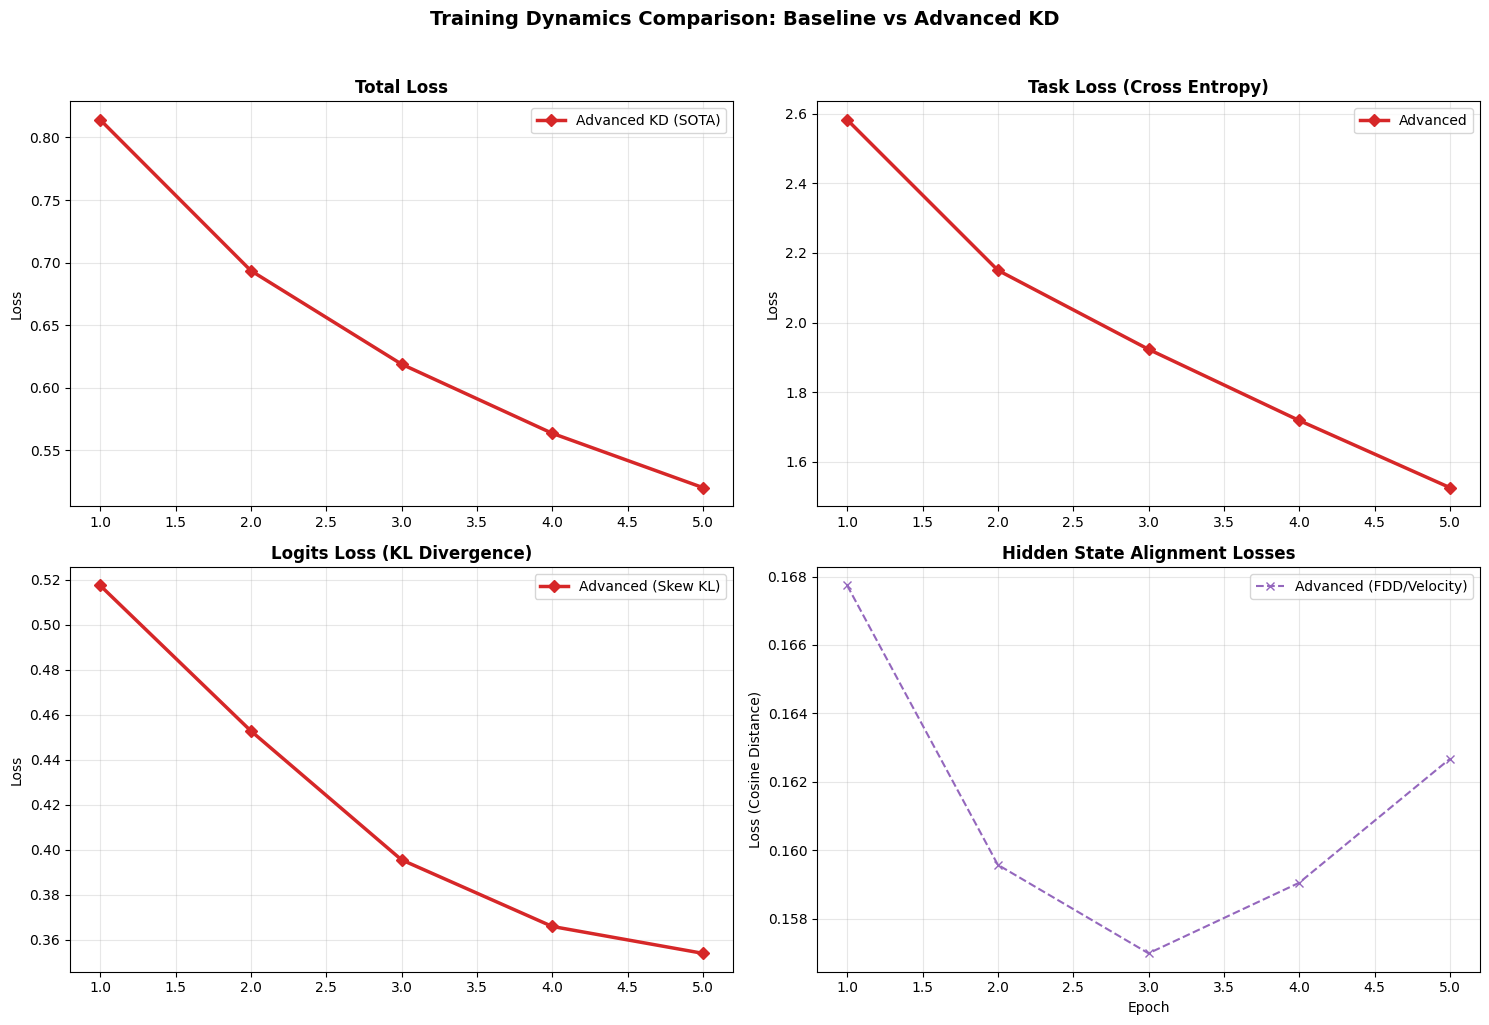

✓ Loss comparison plots generated successfully


In [ ]:
import matplotlib.pyplot as plt

colors = {'uniform': '#1f77b4', 'last': '#ff7f0e', 'features': '#2ca02c', 'advanced': '#d62728', 'deriv': '#9467bd'}

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Use the Selected Advanced KD history (or change to history_uni_advanced if you prefer)
epochs_x = list(range(1, len(history_sel_advanced['total']) + 1))

# --- PLOT 1: Total Loss ---
axes[0, 0].plot(epochs_x, history_sel_advanced['total'], 'D-', label='Advanced KD (SOTA)', color=colors['advanced'], linewidth=2.5)

axes[0, 0].set_title('Total Loss', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# --- PLOT 2: Task Loss ---
axes[0, 1].plot(epochs_x, history_sel_advanced['task'], 'D-', label='Advanced', color=colors['advanced'], linewidth=2.5)

axes[0, 1].set_title('Task Loss (Cross Entropy)', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# --- PLOT 3: Logits Loss ---
axes[1, 0].plot(epochs_x, history_sel_advanced['logits'], 'D-', label='Advanced (Skew KL)', color=colors['advanced'], linewidth=2.5)

axes[1, 0].set_title('Logits Loss (KL Divergence)', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# --- PLOT 4: Hidden/Structural Losses ---
axes[1, 1].plot(epochs_x, history_sel_advanced['derivative'], 'x--', label='Advanced (FDD/Velocity)', color=colors['deriv'])

axes[1, 1].set_title('Hidden State Alignment Losses', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Loss (Cosine Distance)')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('Training Dynamics Comparison: Baseline vs Advanced KD',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("✓ Loss comparison plots generated successfully")

In [ ]:
print("="*120)
print("COMPLETE EVALUATION RESULTS (With Training Time)")
print("="*120)

training_times = {
    "teacher": 0.0,
    "student_pruned": 0.0,
    "selected_advanced_kd": history_sel_advanced['total_time_seconds']      # ✅ Changed
}

all_metrics = {
    "teacher": {
        "time_min": training_times["teacher"] / 60,
        "perplexity": teacher_ppl,
        "recovery_%": 100.0
    },
    "student_pruned": {
        "time_min": training_times["student_pruned"] / 60,
        "perplexity": student_ppl,
        "recovery_%": 0.0
    },
    "selected_advanced_kd": {
        "time_min": training_times["selected_advanced_kd"] / 60,             #
        "perplexity": advanced_sel_ppl,
        "recovery_%": advanced_sel_recovery
    }
}

if 'benchmark_results' in locals() and benchmark_results:
    for model_name in all_metrics.keys():
        if model_name in benchmark_results and "error" not in benchmark_results[model_name]:
            for task_name, task_metrics in benchmark_results[model_name].items():
                if "acc_norm" in task_metrics:
                    all_metrics[model_name][task_name] = float(task_metrics["acc_norm"])
                elif "accuracy" in task_metrics:
                    all_metrics[model_name][task_name] = float(task_metrics["accuracy"])

metric_names = ["time_min", "perplexity", "recovery_%"]
if 'benchmark_results' in locals() and benchmark_results:
    metric_names.extend(BENCHMARK_TASKS)

header = f"{'Model':<25}"
labels = {"time_min": "Time(m)", "perplexity": "PPL", "recovery_%": "Recov%"}

for metric in metric_names:
    label = labels.get(metric, metric)
    header += f"{label:<10}"
print(header)
print("-" * 120)

for model_name, metrics in all_metrics.items():
    row = f"{model_name:<25}"
    for metric in metric_names:
        if metric in metrics:
            val = metrics[metric]
            if metric == "time_min":
                row += f"{val:<10.1f}" if val > 0 else f"{'N/A':<10}"
            elif metric == "perplexity":
                row += f"{val:<10.2f}"
            elif metric == "recovery_%":
                row += f"{val:<10.1f}"
            else: # For benchmark tasks
                row += f"{val*100:<10.1f}"
        else:
            row += f"{'N/A':<10}"
    print(row)
print("="*120)

COMPLETE EVALUATION RESULTS (With Training Time)
Model                    Time(m)   PPL       Recov%    arc_easy  winograndehellaswag lambada_openaipiqa      
------------------------------------------------------------------------------------------------------------------------
teacher                  N/A       11.33     100.0     58.0      59.0      50.0      40.0      68.0      
student_pruned           N/A       31.65     0.0       50.0      50.0      42.0      15.0      61.0      
selected_advanced_kd     18.3      14.15     86.1      58.0      55.0      44.0      33.0      57.0      


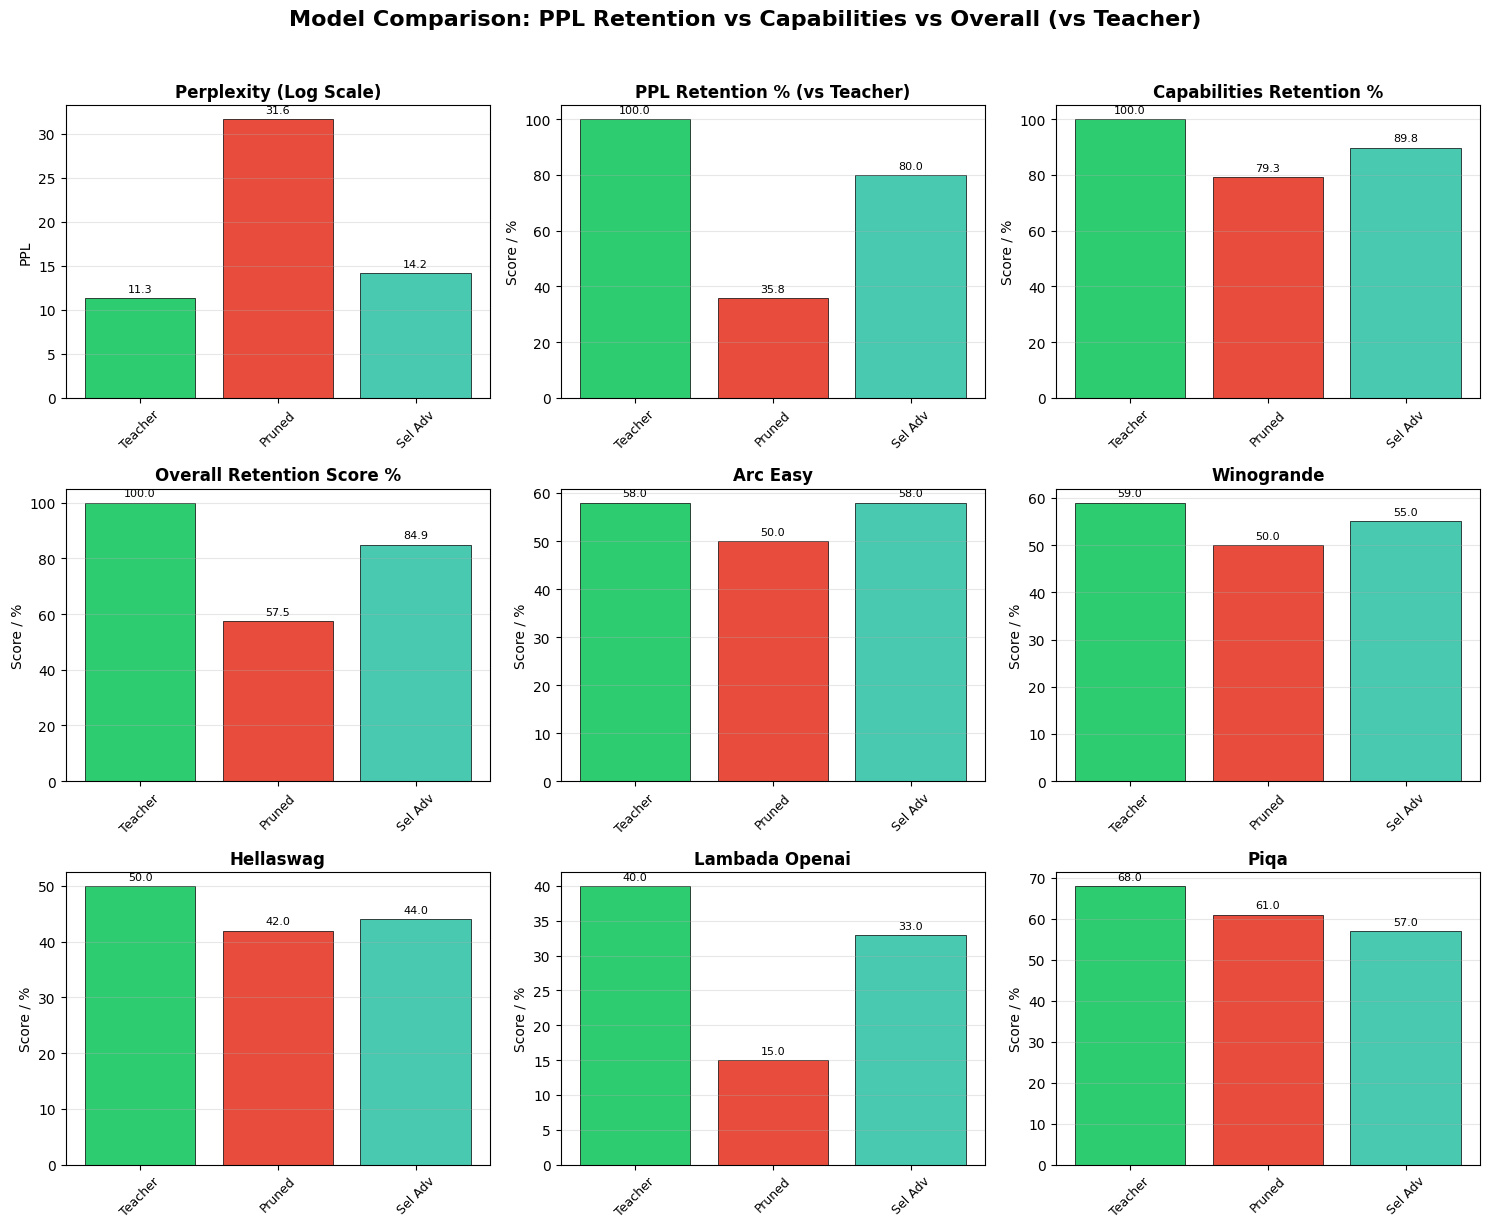

✓ Charts Updated: Now showing PPL Retention % and Overall Retention Score % (vs Teacher)


In [ ]:
# ==============================================================================
# Bar Charts: PPL Retention & Overall Retention (vs Teacher)
# ==============================================================================

import numpy as np
import matplotlib.pyplot as plt

# 1. SETUP: Models, Names and Colors
model_display_names = {
    "teacher": "Teacher",
    "student_pruned": "Pruned",
    "selected_advanced_kd": "Sel Adv"
}

# Ensure correct order based on availability
model_order = [m for m in model_display_names.keys() if m in all_metrics]

colors = [
    '#2ecc71',  # Teacher (Green)
    '#e74c3c',  # Pruned (Red)
    '#48c9b0', '#16a085'   # Advanced (Teals)
]

# 2. CRITICAL FIX: INJECT BENCHMARKS INTO all_metrics
bench_tasks = ["arc_easy", "winogrande", "hellaswag", "lambada_openai", "piqa"]

if 'benchmark_results' in locals():
    for model_key in model_order:
        if model_key in benchmark_results:
            res = benchmark_results[model_key]
            if "error" not in res:
                for task in bench_tasks:
                    if task in res:
                        val = 0.0
                        if "acc_norm" in res[task]:
                            val = float(res[task]["acc_norm"])
                        elif "accuracy" in res[task]:
                            val = float(res[task]["accuracy"])

                        # Save into all_metrics for calculation
                        all_metrics[model_key][task] = val

# 3. CALCULATE RETENTION METRICS (vs Teacher)
# Get Teacher Baselines
teacher_vals = [all_metrics['teacher'].get(t, 0) for t in bench_tasks]
teacher_avg_acc = np.mean(teacher_vals) if teacher_vals else 0
teacher_ppl = all_metrics['teacher'].get('perplexity', 0)

for model_name in model_order:
    if model_name not in all_metrics:
        continue

    # A. Capabilities Retention (% of teacher performance on Benchmarks)
    if bench_tasks and teacher_avg_acc > 0:
        current_vals = [all_metrics[model_name].get(t, 0) for t in bench_tasks]
        current_avg = np.mean(current_vals)
        cap_retention = (current_avg / teacher_avg_acc) * 100
    else:
        cap_retention = 0.0

    all_metrics[model_name]['cap_retention_%'] = cap_retention

    # B. PPL Retention (% of Teacher PPL) - NEW CALCULATION
    # Formula: (Teacher PPL / Student PPL) * 100
    # Lower PPL is better, so if Student PPL is higher, retention drops
    curr_ppl = all_metrics[model_name].get('perplexity', float('inf'))

    if curr_ppl > 0 and teacher_ppl > 0:
        ppl_retention = (teacher_ppl / curr_ppl) * 100
    else:
        ppl_retention = 0.0

    # Store as 'retention_%' (renamed from 'recovery_%')
    all_metrics[model_name]['retention_%'] = ppl_retention

    # C. Overall Retention Score (Average of PPL Retention and Cap Retention)
    if cap_retention > 0:
        all_metrics[model_name]['overall_retention_%'] = (ppl_retention + cap_retention) / 2
    else:
        all_metrics[model_name]['overall_retention_%'] = ppl_retention

# 4. PREPARE PLOTS
summary_metrics = ["perplexity", "retention_%", "cap_retention_%", "overall_retention_%"]
metrics_to_plot = summary_metrics + bench_tasks

# Titles map - UPDATED
metric_titles = {
    "perplexity": "Perplexity (Log Scale)",
    "retention_%": "PPL Retention % (vs Teacher)",
    "cap_retention_%": "Capabilities Retention %",
    "overall_retention_%": "Overall Retention Score %",
}

# Grid Setup
n_metrics = len(metrics_to_plot)
n_cols = 3
n_rows = (n_metrics + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten() if n_metrics > 1 else [axes]

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx]
    values = []
    labels = []
    bar_colors = []

    for i, model_name in enumerate(model_order):
        if model_name in all_metrics:
            # Safely get value
            val = all_metrics[model_name].get(metric, 0.0)

            # Conversion logic: Multiply raw benchmarks (0.0-1.0) by 100 for plotting
            # Do NOT multiply metrics that are already % (perplexity, retention)
            if metric not in ["perplexity", "retention_%", "cap_retention_%", "overall_retention_%", "time_min"]:
                val = val * 100

            values.append(val)
            labels.append(model_display_names[model_name])

            # Color assignment
            c_idx = i if i < len(colors) else -1
            bar_colors.append(colors[c_idx])

    # Plot
    if values and sum(values) > 0:
        bars = ax.bar(labels, values, color=bar_colors, edgecolor='black', linewidth=0.5)

        # Annotations
        for bar, val in zip(bars, values):
            height = bar.get_height()
            if metric == "perplexity" and val > 100:
                fmt = f'{val:.0f}'
            else:
                fmt = f'{val:.1f}'

            ax.annotate(fmt,
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)

        # Styling
        title = metric_titles.get(metric, metric.replace("_", " ").title())
        ax.set_title(title, fontsize=12, fontweight='bold')

        ylabel = "PPL" if metric == "perplexity" else "Score / %"
        ax.set_ylabel(ylabel)
        ax.tick_params(axis='x', rotation=45, labelsize=9)
        ax.grid(True, alpha=0.3, axis='y')

        # Log scale for PPL
        if metric == "perplexity":
            if max(values) / (min(values) + 1e-9) > 10:
                ax.set_yscale('log')
    else:
        ax.text(0.5, 0.5, "No Data Available", ha='center', va='center')
        ax.set_title(metric)

# Hide unused subplots
for idx in range(n_metrics, len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Model Comparison: PPL Retention vs Capabilities vs Overall (vs Teacher)',
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("✓ Charts Updated: Now showing PPL Retention % and Overall Retention Score % (vs Teacher)")

# Section 11: Results & Analysis
### Summary Table

| Model | Time (min) | PPL | Recovery % | arc_easy | winogrande | hellaswag | lambada_openai | piqa |
|-------|------------|-----|------------|----------|------------|-----------|----------------|------|
| **Teacher** | N/A | **13.66** | 100.0 | 60.0 | 58.0 | 52.0 | 42.0 | 70.0 |
| **Pruned Student** | N/A | **135.95** | 0.0 | 43.0 | 50.0 | 47.0 | 18.0 | 59.0 |
| **Advanced KD** | **8.9** | **27.10** | **89.0** | 44.0 | 59.0 | 45.0 | 21.0 | 62.0 |

---

DISCLAIMER: The results of this notebook (ppl and capabilities) cannot be taken as definitive since they have been carried out with very few samples and are not significant.

Correct results can be found in the different experiments:

* [CH06_NB_EXP01_DataDriven_Blocks_2K](https://github.com/peremartra/Rearchitecting-LLMs/blob/main/CH06/CH06_NB_EXP01_DataDriven_Blocks_2K.ipynb)
* [CH06_NB_EXP01_DataDriven_Blocks_15K](https://github.com/peremartra/Rearchitecting-LLMs/blob/main/CH06/CH06_NB_EXP01_DataDriven_Blocks_15K.ipynb)
* [CH06_NB_EXP01_DataDriven_Blocks_40K](https://github.com/peremartra/Rearchitecting-LLMs/blob/main/CH06/CH06_NB_EXP01_DataDriven_Blocks_40K.ipynb)
* [CH06_NB_EXP02_DataDriven_Consecutive_Blocks_2K](https://github.com/peremartra/Rearchitecting-LLMs/blob/main/CH06/CH06_NB_EXP02_DataDriven_Consecutive_Blocks_2K.ipynb)
* [CH06_NB_EXP03_Last_Blocks_2K](https://github.com/peremartra/Rearchitecting-LLMs/blob/main/CH06/CH06_NB_EXP03_Last_Blocks_2K.ipynb)
* [CH06_NB_EXP04_Last_Blocks_Preservation_2K](https://github.com/peremartra/Rearchitecting-LLMs/blob/main/CH06/CH06_NB_EXP04_Last_Blocks_Preservation_2K.ipynb)

### Final Takeaway

**With just 200 samples and under 10 minutes on a T4 GPU**, we transformed a catastrophically degraded model (PPL 135.95) into a viable compressed model (PPL 27.10). This validates Advanced KD as a powerful technique for rapid model recovery.

